This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [13]:
import numpy as np
import pandas as pd

file = "./data/data_000637.txt"
N = [i for i in range(1,10000)]
DataFrame = pd.read_csv(file, skiprows=N)
DataFrame

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,49,3869200267,777,13
1,1,0,50,3869200267,776,22
2,1,0,47,3869200267,785,14
3,1,0,63,3869200267,921,28
4,1,0,64,3869200267,924,15
...,...,...,...,...,...,...
1300716,1,0,62,3869211171,762,14
1300717,1,1,4,3869211171,763,11
1300718,1,0,64,3869211171,764,0
1300719,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [14]:
x = DataFrame['ORBIT_CNT'].value_counts()
print(x)

3869208772    351
3869207118    337
3869209661    324
3869206967    322
3869206506    305
             ... 
3869204462      3
3869205800      2
3869203571      2
3869206180      1
3869204142      1
Name: ORBIT_CNT, Length: 10901, dtype: int64


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [15]:
TDC_Time = DataFrame['TDC_MEAS'] * 25/30 
BX_Time = DataFrame['BX_COUNTER'] *25
ORBIT_Time = DataFrame['ORBIT_CNT']*BX_Time

Time = TDC_Time + BX_Time + ORBIT_Time #time in ns

Duration = abs(Time[Time.size-1] - Time[0])
Duration_s = Duration*pow(10,-9)


#find the time in hours, minutes, seconds
hours = Duration_s / 3600
minutes = (hours - int(hours))*60
seconds = (minutes - int(minutes))*60
print("Total time of data taking considering a fraction of measurements:")
print(Duration, "ns =", Duration_s, "s =", int(hours), "h", int(minutes), "min", int(seconds), "s")

Total time of data taking considering a fraction of measurements:
1450742379295.8281 ns = 1450.7423792958282 s = 0 h 24 min 10 s


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [16]:
#read all data file
df = pd.read_csv(file)

timeTot = df['TDC_MEAS'] * 25/30 + df['BX_COUNTER'] * 25 + df['ORBIT_CNT']*df['BX_COUNTER']*25 
df['ABS_TIME'] = abs(timeTot - timeTot[0])

df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.437500e-01
2,1,0,63,3869200167,2553,28,1.731467e+13
3,1,0,64,3869200167,2558,19,1.779832e+13
4,1,0,64,3869200167,2760,25,3.733778e+13
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,1.559286e+14
1310716,1,1,4,3869211171,763,11,1.558318e+14
1310717,1,0,64,3869211171,764,0,1.557351e+14
1310718,1,0,139,3869211171,769,0,1.552514e+14


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [17]:
TDC_groups = df.groupby('TDC_CHANNEL').sum().sort_values(by='ORBIT_CNT').iloc[-3:]
max_val = [3,2,1]
TDC_groups['TOP'] = max_val
TDC_groups

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME,TOP
TDC_CHANNEL,,,,,,,
63,64642,918,250113227630194,115482430,938192,6.171815e+18,3
64,66020,1439,255444994368975,117767051,962195,6.316821e+18,2
139,108059,32442,418102549486957,192477704,0,1.034423e+19,1


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [18]:
orbits = len(df.groupby('ORBIT_CNT').size())
print("The number of non-empty orbits is:", orbits,'\n')

ch139 = len(df[df['TDC_CHANNEL'] == 139].groupby('ORBIT_CNT').size())
print("The number of non-empty orbits from TDC_CHANNEL=139:", ch139)

The number of non-empty orbits is: 11001 

The number of non-empty orbits from TDC_CHANNEL=139: 10976


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

FPGA
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

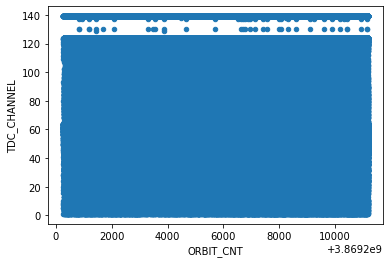

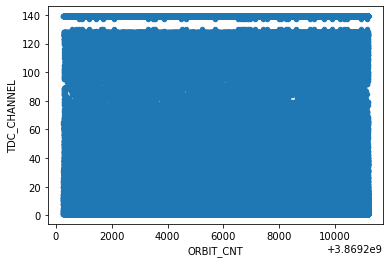

In [19]:
FPGA = DataFrame.groupby('FPGA')
FPGA.plot.scatter("ORBIT_CNT", "TDC_CHANNEL")